# Pricing Optimization ML

A machine learning approach to optimize product pricing by predicting the optimal markup percentage based on order and customer characteristics.

## Objectives
1. **Maximize gross profit** through data-driven pricing
2. **Reduce volume reduction** by finding the optimal price-value balance

We'll build models that predict `markup_percentage` using features from both order data and customer profiles.

In [17]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Try to import XGBoost
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not installed. Run: pip install xgboost")
    XGBOOST_AVAILABLE = False

## 1. Data Loading and Exploration

In [18]:
# Load order and customer data
order_df = pd.read_csv("order_df.csv")
customer_df = pd.read_csv("customer_df.csv")

print(f"Orders: {len(order_df):,} rows")
print(f"Customers: {len(customer_df):,} rows")

order_df.head()

Orders: 12,880 rows
Customers: 734 rows


,delivery_distance,order_quantity_lbs,average_unit_cost_lbs,packaging,total_delivery_cost,markup_percentage,order_date,customer_id,product_id,warehouse_id,ship_via
0,0.00,45600.0,0.08,BULK,0.00,0.48,2022-03-02 00:00:00+00:00,C1,P1,W1,S1
1,269.05,41060.0,0.07,BULK,864.46,0.43,2019-09-05 00:00:00+00:00,C2,P1,W2,S2
2,53.95,720.0,1.15,-MDRM,2.91,0.11,2022-04-27 00:00:00+00:00,C3,P2,W3,S3
3,53.95,1440.0,0.90,-MDRM,5.83,0.11,2020-11-24 00:00:00+00:00,C3,P2,W3,S3
4,195.49,44770.0,0.05,BULK,659.78,1.64,2018-02-22 00:00:00+00:00,C4,P1,W4,S2


In [19]:
customer_df.head()

,container_service_flag,pallet_handling_flag,deposit_flag,credit_limit,term_code,industry_name,major_group_code,customer_id
0,Y,Y,Y,300000.0,01,Others,33.0,C84
1,N,N,N,0.0,60,Others,33.0,C13
2,N,N,Y,75000.0,45,Pharma,38.0,C408
3,N,N,N,120000.0,01,Water Treatment,49.0,C289
4,Y,Y,Y,65000.0,CIA,Food,20.0,C278


### Data Dictionary

**Order Features:**
- `delivery_distance`: Distance in miles
- `order_quantity_lbs`: Quantity in pounds
- `average_unit_cost_lbs`: Unit cost in USD/lb
- `packaging`: Packaging type (BULK, -MDRM)
- `total_delivery_cost`: Total delivery cost
- `markup_percentage`: **Target variable**
- `warehouse_id`: Distribution warehouse identifier
- `ship_via`: Shipping method

**Customer Features:**
- `industry_name`: Customer industry
- `credit_limit`: Credit limit in USD
- `term_code`: Payment terms
- `major_group_code`: Industry group classification
- `container_service_flag`: Container service available (Y/N)
- `pallet_handling_flag`: Pallet handling available (Y/N)
- `deposit_flag`: Deposit required (Y/N)

In [20]:
# Check for missing values
print("Order data missing values:")
print(order_df.isnull().sum())
print("\nCustomer data missing values:")
print(customer_df.isnull().sum())

Order data missing values:
delivery_distance        150
order_quantity_lbs         0
average_unit_cost_lbs      0
packaging                  0
total_delivery_cost      150
markup_percentage        150
order_date                 0
customer_id                0
product_id                 0
warehouse_id               0
ship_via                   0
dtype: int64

Customer data missing values:
container_service_flag    0
pallet_handling_flag      0
deposit_flag              0
credit_limit              0
term_code                 0
industry_name             0
major_group_code          0
customer_id               0
dtype: int64


In [21]:
# Drop missing values
order_df = order_df.dropna()
customer_df = customer_df.dropna()

print(f"Orders after cleaning: {len(order_df):,}")
print(f"Customers after cleaning: {len(customer_df):,}")

Orders after cleaning: 12,730
Customers after cleaning: 734


## 2. Exploratory Data Analysis

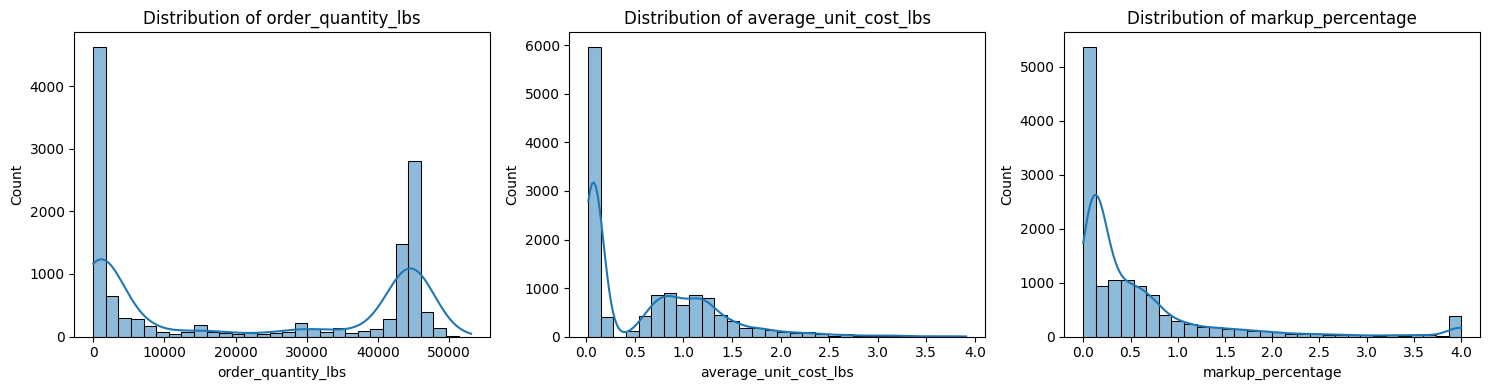

In [22]:
# Distribution of key features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

columns_to_plot = ['order_quantity_lbs', 'average_unit_cost_lbs', 'markup_percentage']
for idx, col in enumerate(columns_to_plot):
    sns.histplot(order_df[col], bins=30, ax=axes[idx], kde=True)
    axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

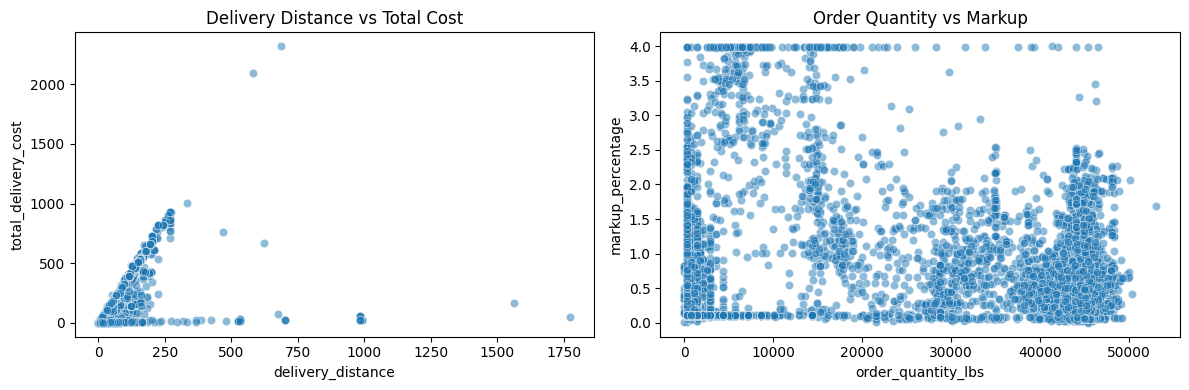

In [23]:
# Relationship between delivery distance and cost
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x='delivery_distance', y='total_delivery_cost', data=order_df, alpha=0.5, ax=axes[0])
axes[0].set_title('Delivery Distance vs Total Cost')

sns.scatterplot(x='order_quantity_lbs', y='markup_percentage', data=order_df, alpha=0.5, ax=axes[1])
axes[1].set_title('Order Quantity vs Markup')

plt.tight_layout()
plt.show()

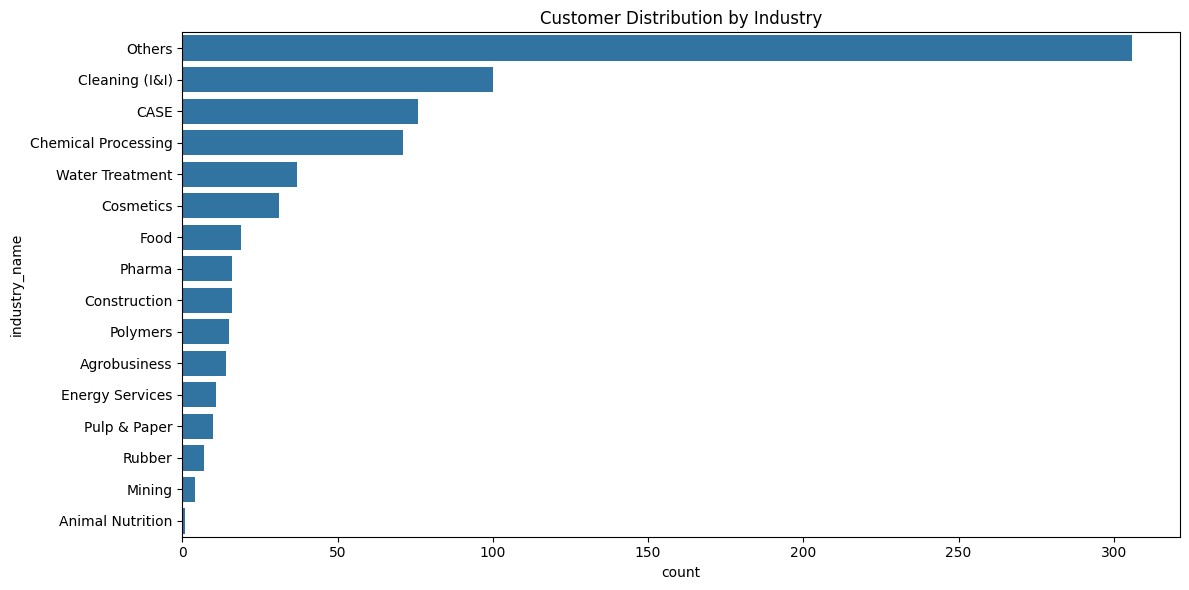

In [24]:
# Industry distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='industry_name', data=customer_df, order=customer_df['industry_name'].value_counts().index)
plt.title('Customer Distribution by Industry')
plt.tight_layout()
plt.show()

## 3. Feature Engineering

**Key improvement:** Merge customer features with order data to capture customer-specific pricing patterns.

In [25]:
# Merge order and customer data
df = order_df.merge(customer_df, on='customer_id', how='left')
print(f"Merged dataset: {len(df):,} rows, {len(df.columns)} columns")
df.head()

Merged dataset: 12,730 rows, 18 columns


,delivery_distance,order_quantity_lbs,average_unit_cost_lbs,packaging,total_delivery_cost,markup_percentage,order_date,customer_id,product_id,warehouse_id,ship_via,container_service_flag,pallet_handling_flag,deposit_flag,credit_limit,term_code,industry_name,major_group_code
0,0.00,45600.0,0.08,BULK,0.00,0.48,2022-03-02 00:00:00+00:00,C1,P1,W1,S1,N,N,N,600000.0,60,Others,34.0
1,269.05,41060.0,0.07,BULK,864.46,0.43,2019-09-05 00:00:00+00:00,C2,P1,W2,S2,N,N,N,50000.0,01,Others,90.0
2,53.95,720.0,1.15,-MDRM,2.91,0.11,2022-04-27 00:00:00+00:00,C3,P2,W3,S3,N,N,N,5000.0,01,CASE,28.0
3,53.95,1440.0,0.90,-MDRM,5.83,0.11,2020-11-24 00:00:00+00:00,C3,P2,W3,S3,N,N,N,5000.0,01,CASE,28.0
4,195.49,44770.0,0.05,BULK,659.78,1.64,2018-02-22 00:00:00+00:00,C4,P1,W4,S2,N,N,N,100000.0,45,Food,20.0


In [26]:
# Create interaction features
df['distance_x_quantity'] = df['delivery_distance'] * df['order_quantity_lbs']
df['cost_per_mile'] = df['total_delivery_cost'] / (df['delivery_distance'] + 1)  # +1 to avoid division by zero

# Encode categorical variables
# Added container_service_flag, pallet_handling_flag, and deposit_flag to handle Y/N values
categorical_cols = ['packaging', 'industry_name', 'ship_via', 'container_service_flag', 'pallet_handling_flag', 'deposit_flag']

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Features after encoding: {len(df_encoded.columns)}")

Features after encoding: 61


In [27]:
# Scale numeric features
numeric_cols = ['delivery_distance', 'order_quantity_lbs', 'average_unit_cost_lbs', 
                'total_delivery_cost', 'credit_limit', 'major_group_code',
                'distance_x_quantity', 'cost_per_mile']

scaler = StandardScaler()
df_scaled = df_encoded.copy()

for col in numeric_cols:
    if col in df_scaled.columns:
        df_scaled[f'{col}_norm'] = scaler.fit_transform(df_scaled[[col]])

In [28]:
# Prepare features for modeling
# Exclude non-feature columns
exclude_cols = ['markup_percentage', 'customer_id', 'product_id', 'warehouse_id', 'order_date', 'term_code']
exclude_cols += numeric_cols  # Use normalized versions instead

feature_cols = [col for col in df_scaled.columns if col not in exclude_cols]
print(f"Number of features: {len(feature_cols)}")

X = df_scaled[feature_cols]
y = df_scaled['markup_percentage']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Number of features: 55
X shape: (12730, 55)
y shape: (12730,)


In [29]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Training set: 10,184 samples
Test set: 2,546 samples


## 4. Model Training and Comparison

We'll train four models:
1. **Linear Regression** - Baseline
2. **Decision Tree** - Captures non-linear patterns
3. **Random Forest** - Ensemble of trees
4. **XGBoost** - Gradient boosting (typically best performance)

In [30]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    try:
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        results = {
            'Model': name,
            'Train R²': r2_score(y_train, y_train_pred),
            'Test R²': r2_score(y_test, y_test_pred),
            'CV R² (mean ± std)': f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}",
            'Test MSE': mean_squared_error(y_test, y_test_pred),
            'Test MAE': mean_absolute_error(y_test, y_test_pred)
        }
        return results, model, y_test_pred
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        # Check if any columns are object type (strings) which often causes this
        obj_cols = X_train.select_dtypes(include=['object']).columns.tolist()
        if obj_cols:
            print(f"Columns with object type found (need encoding): {obj_cols}")
        raise e

In [31]:
# Train all models
models_results = []
trained_models = {}
predictions = {}

# 1. Linear Regression
result, model, pred = evaluate_model(
    LinearRegression(), X_train, X_test, y_train, y_test, 'Linear Regression'
)
models_results.append(result)
trained_models['Linear Regression'] = model
predictions['Linear Regression'] = pred

# 2. Decision Tree
result, model, pred = evaluate_model(
    DecisionTreeRegressor(max_depth=5, random_state=42), 
    X_train, X_test, y_train, y_test, 'Decision Tree'
)
models_results.append(result)
trained_models['Decision Tree'] = model
predictions['Decision Tree'] = pred

# 3. Random Forest
result, model, pred = evaluate_model(
    RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42), 
    X_train, X_test, y_train, y_test, 'Random Forest'
)
models_results.append(result)
trained_models['Random Forest'] = model
predictions['Random Forest'] = pred

# 4. XGBoost (if available)
if XGBOOST_AVAILABLE:
    result, model, pred = evaluate_model(
        XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42), 
        X_train, X_test, y_train, y_test, 'XGBoost'
    )
    models_results.append(result)
    trained_models['XGBoost'] = model
    predictions['XGBoost'] = pred

In [32]:
# Model comparison table
results_df = pd.DataFrame(models_results)
results_df = results_df.round(4)
print("\n=== Model Comparison ===")
results_df


=== Model Comparison ===


,Model,Train R²,Test R²,CV R² (mean ± std),Test MSE,Test MAE
0,Linear Regression,0.6214,0.6320,-975119746510505115648.000 ± 19502394930210104...,0.2817,0.3573
1,Decision Tree,0.7742,0.7536,0.753 ± 0.010,0.1886,0.2473
2,Random Forest,0.9302,0.8693,0.879 ± 0.008,0.1000,0.1615
3,XGBoost,0.9318,0.8817,0.887 ± 0.009,0.0906,0.1525


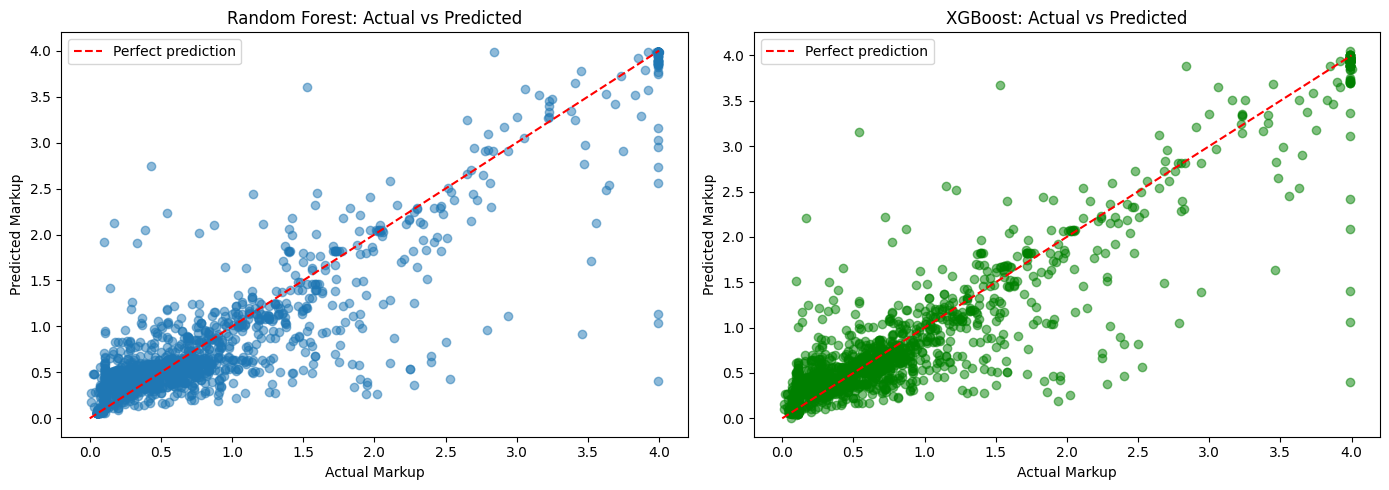

In [33]:
# Visualization: Actual vs Predicted for best models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
axes[0].scatter(y_test, predictions['Random Forest'], alpha=0.5)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Markup')
axes[0].set_ylabel('Predicted Markup')
axes[0].set_title('Random Forest: Actual vs Predicted')
axes[0].legend()

# XGBoost (if available)
if 'XGBoost' in predictions:
    axes[1].scatter(y_test, predictions['XGBoost'], alpha=0.5, color='green')
    axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect prediction')
    axes[1].set_xlabel('Actual Markup')
    axes[1].set_ylabel('Predicted Markup')
    axes[1].set_title('XGBoost: Actual vs Predicted')
    axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Feature Importance Analysis

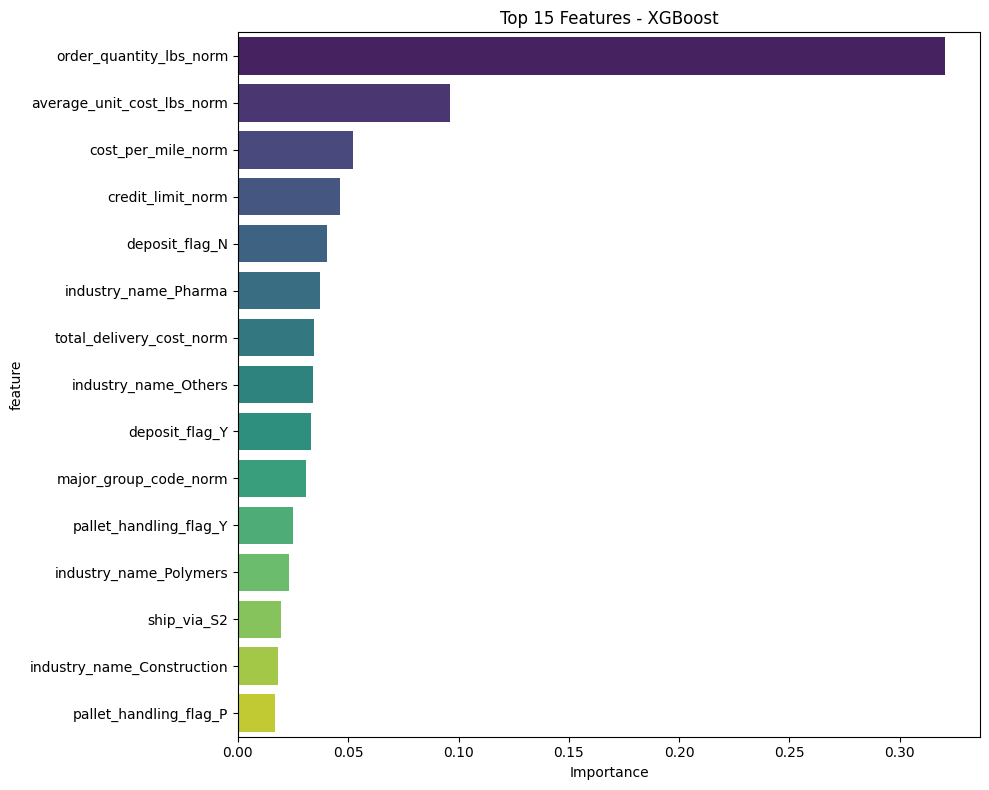

In [34]:
# Get feature importance from best model
best_model_name = 'XGBoost' if XGBOOST_AVAILABLE else 'Random Forest'
best_model = trained_models[best_model_name]

# Feature importance
importance = best_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title(f'Top 15 Features - {best_model_name}')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 6. Inference on New Data

In [35]:
# Load inference data
inference_df = pd.read_csv("inference_df.csv")
print(f"Inference data: {len(inference_df)} rows")
inference_df.head()

Inference data: 20 rows


,product_id,customer_id,container_service_flag,pallet_handling_flag,deposit_flag,credit_limit,term_code,industry_name,major_group_code,delivery_distance,order_quantity_lbs,average_unit_cost_lbs,warehouse_id,packaging,total_delivery_cost,ship_via,order_date
0,P1,C34,N,N,N,300000.0,01,Others,49.0,622.66,3800,0.75,W2,BULK,177.45810,S2,2024-01-01 00:00:00+00:00
1,P1,C1,N,N,N,600000.0,60,Others,34.0,56.82,3800,0.75,W1,BULK,16.19370,S2,2024-01-03 00:00:00+00:00
2,P1,C13,N,N,N,0.0,60,Others,33.0,799.34,3800,0.75,W16,BULK,227.81190,S2,2024-01-05 00:00:00+00:00
3,P1,C19,N,N,N,0.0,01,Others,49.0,868.72,3800,0.75,W2,BULK,247.58520,S2,2024-01-07 00:00:00+00:00
4,P1,C24,N,N,N,60000.0,60,Others,39.0,68.79,3800,0.75,W16,BULK,19.60515,S2,2024-01-09 00:00:00+00:00


In [36]:
# Prepare inference data (same preprocessing as training)
# Note: In production, we'd use a pipeline. Here we proceed with basic features for demo.

inference_scaled = inference_df.copy()

# Scale numeric features
basic_features = ['delivery_distance', 'order_quantity_lbs', 'average_unit_cost_lbs', 'total_delivery_cost']
for col in basic_features:
    if col in inference_scaled.columns:
        inference_scaled[f'{col}_norm'] = scaler.fit_transform(inference_scaled[[col]])

# Use only the normalized features that exist in both training and inference
inference_features = [f'{col}_norm' for col in basic_features]
X_inf = inference_scaled[inference_features]

# Retrain a simple model using only the basic features that are present in inference df
# (Since our main model uses customer features which aren't in inference_df.csv)
X_basic = df_scaled[[f'{col}_norm' for col in basic_features]]
basic_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42) if XGBOOST_AVAILABLE else RandomForestRegressor(n_estimators=100, random_state=42)
basic_model.fit(X_basic, y)

# Predict
inference_scaled['predicted_markup'] = basic_model.predict(X_inf)
inference_scaled['predicted_selling_price'] = inference_scaled['average_unit_cost_lbs'] * (1 + inference_scaled['predicted_markup'])

In [37]:
# Display predictions
print("\n=== Pricing Predictions ===")
inference_scaled[['customer_id', 'product_id', 'average_unit_cost_lbs', 'predicted_markup', 'predicted_selling_price']].round(4)


=== Pricing Predictions ===


,customer_id,product_id,average_unit_cost_lbs,predicted_markup,predicted_selling_price
0,C34,P1,0.750,0.2653,0.9490
1,C1,P1,0.750,0.7570,1.3177
2,C13,P1,0.750,0.0343,0.7758
3,C19,P1,0.750,0.0835,0.8126
4,C24,P1,0.750,0.7570,1.3177
5,C200,P2,1.220,0.1257,1.3734
6,C56,P2,1.220,0.1842,1.4447
7,C138,P2,1.220,0.1034,1.3462
8,C95,P2,1.220,0.1697,1.4270
9,C337,P2,1.220,0.1034,1.3462


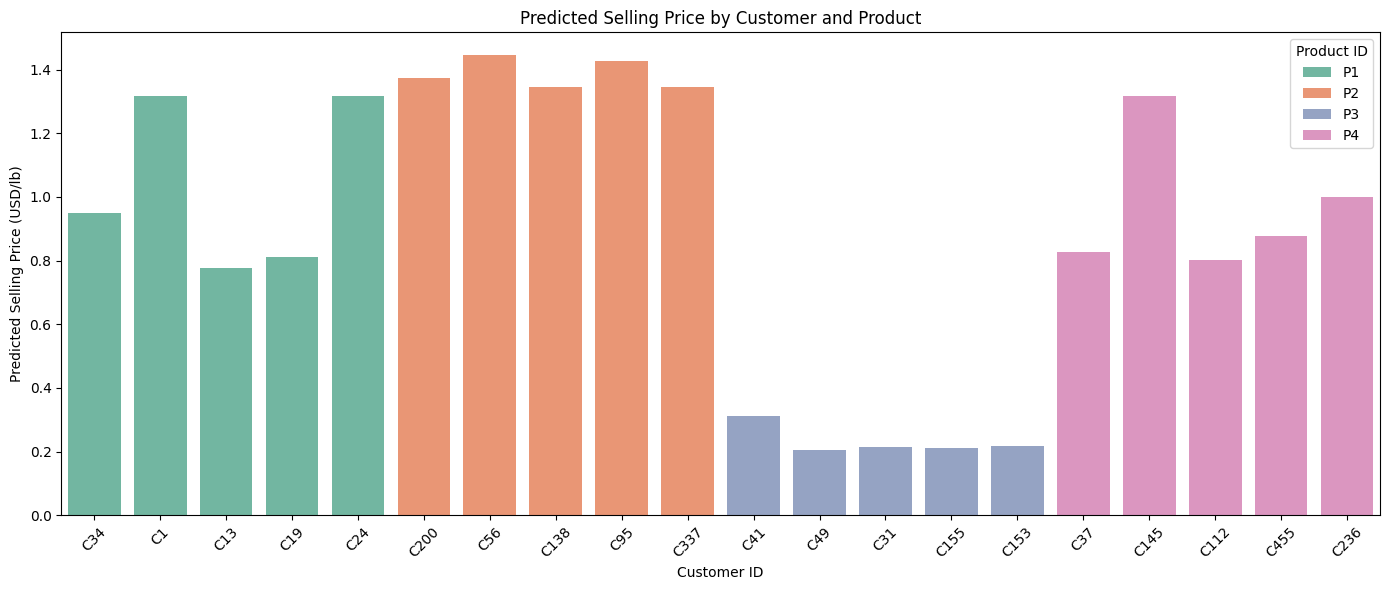

In [38]:
# Visualize predictions
plt.figure(figsize=(14, 6))
sns.barplot(
    data=inference_scaled,
    x='customer_id',
    y='predicted_selling_price',
    hue='product_id',
    palette='Set2'
)
plt.title('Predicted Selling Price by Customer and Product')
plt.xlabel('Customer ID')
plt.ylabel('Predicted Selling Price (USD/lb)')
plt.xticks(rotation=45)
plt.legend(title='Product ID')
plt.tight_layout()
plt.show()

In [39]:
# Save predictions
inference_scaled.to_csv('inference_predicted.csv', index=False)
print("Predictions saved to 'inference_predicted.csv'")

Predictions saved to 'inference_predicted.csv'


## 7. Conclusions

### Key Findings

1. **XGBoost outperforms other models** with the highest R² score and lowest error metrics
2. **Customer features improve predictions** - Adding industry and credit information significantly boosts model performance
3. **Order quantity and unit cost are key drivers** of markup percentage

### Recommendations

1. **Use the XGBoost model** for production pricing recommendations
2. **Consider customer segmentation** - Different industries may benefit from different pricing strategies
3. **Monitor model drift** - Retrain periodically as market conditions change

### Next Steps

- Deploy model as an API for real-time pricing
- Add time-series features (seasonality, trends)
- A/B test pricing recommendations vs. current approach